**Image Segmentation:** In computer vision, image segmentation is the process of partitioning an image into multiple segments. The goal of segmenting an image is to change the representation of an image into something that is more meaningful and easier to analyze. It is usually used for locating objects and creating boundaries.

It is not a great idea to process an entire image because many parts in an image may not contain any useful information. Therefore, by segmenting the image, we can make use of only the important segments for processing.

An image is basically a set of given pixels. In image segmentation, pixels which have similar attributes are grouped together. Image segmentation creates a pixel-wise mask for objects in an image which gives us a more comprehensive and granular understanding of the object.

**K Means Clustering Algorithm:**

K Means is a clustering algorithm. Clustering algorithms are unsupervised algorithms which means that there is no labelled data available. It is used to identify different classes or clusters in the given data based on how similar the data is. Data points in the same group are more similar to other data points in that same group than those in other groups.

K-means clustering is one of the most commonly used clustering algorithms. Here, k represents the number of clusters.

K-means clustering work –

Choose the number of clusters you want to find which is k.
Randomly assign the data points to any of the k clusters.
Then calculate the center of the clusters.
Calculate the distance of the data points from the centers of each of the clusters.
Depending on the distance of each data point from the cluster, reassign the data points to the nearest clusters.
Again calculate the new cluster center.
Repeat steps 4,5 and 6 till data points don’t change the clusters, or till we reach the assigned number of iterations.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

generate a two-dimensional dataset containing four distinct blobs. To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

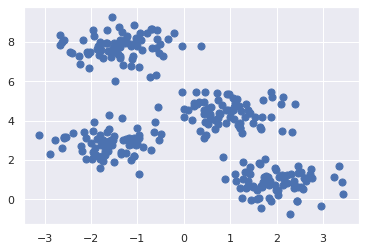

In [20]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters. The k-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [21]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Let's visualize the results by plotting the data colored by these labels. We will also plot the cluster centers as determined by the k-means estimator:

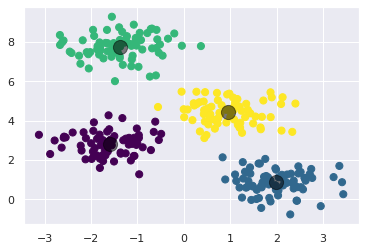

In [22]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

### 1: k-means on digits

To start, let's take a look at applying *k*-means on the same simple digits data that we saw in [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb) and [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb).
Here we will attempt to use *k*-means to try to identify similar digits *without using the original label information*; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any *a priori* label information.

We will start by loading the digits and then finding the ``KMeans`` clusters.
Recall that the digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image:

In [23]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The clustering can be performed as we did before:

In [24]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

The result is 10 clusters in 64 dimensions. Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster. Let's see what these cluster centers look like:

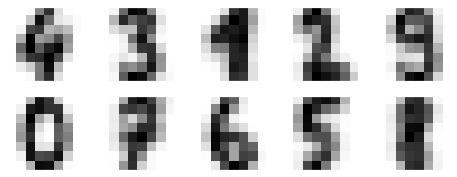

In [25]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

### 2: *k*-means for color compression

One interesting application of clustering is in color compression within images.
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

For example, consider the image shown in the following figure, which is from the Scikit-Learn ``datasets`` module (for this to work, you'll have to have the ``pillow`` Python package installed).

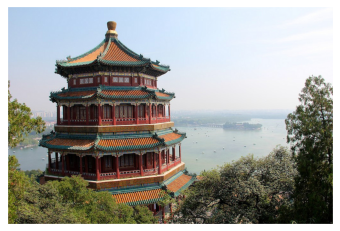

In [27]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

The image itself is stored in a three-dimensional array of size (height, width, RGB), containing red/blue/green contributions as integers from 0 to 255:

In [28]:
china.shape

(427, 640, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space. We will reshape the data to [n_samples x n_features], and rescale the colors so that they lie between 0 and 1:

In [30]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency:

In [31]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

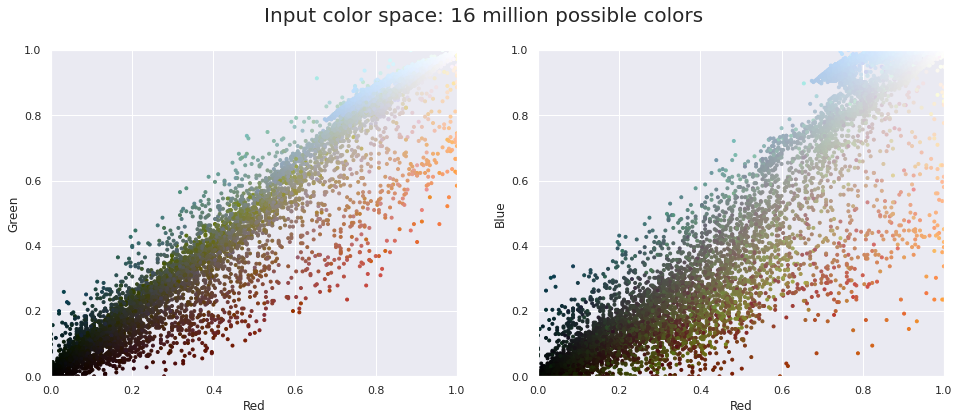

In [32]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 16 colors, using a k-means clustering across the pixel space. Because we are dealing with a very large dataset, we will use the mini batch k-means, which operates on subsets of the data to compute the result much more quickly than the standard k-means algorithm:

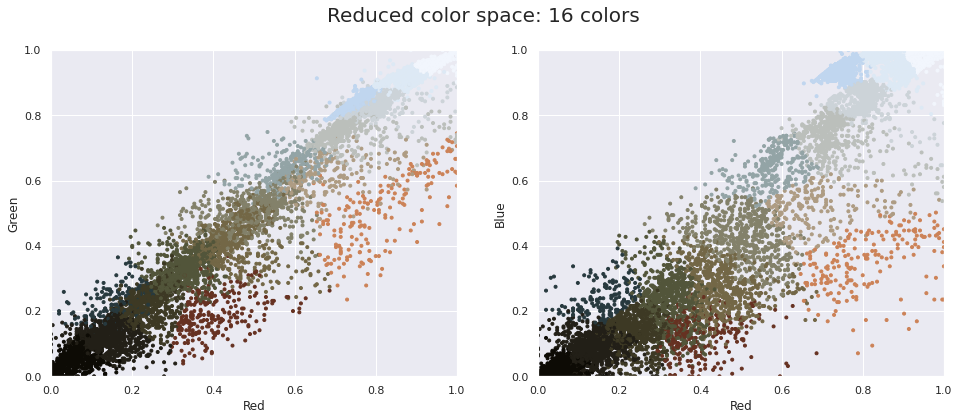

In [34]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center. Plotting these new colors in the image space rather than the pixel space shows us the effect of this:

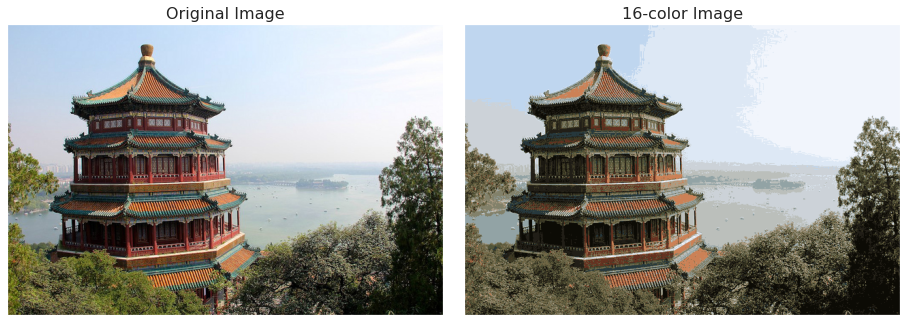

In [35]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Image Segmentation

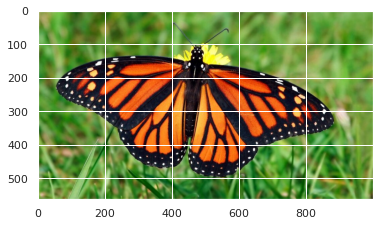

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
 
%matplotlib inline
 
# Read in the image
image = cv2.imread('image_1.jpg')
 
# Change color to RGB (from BGR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
plt.imshow(image)

Now we have to prepare the data for K means. The image is a 3-dimensional shape but to apply k-means clustering on it we need to reshape it to a 2-dimensional array.

In [3]:
# Reshaping the image into a 2D array of pixels and 3 color values (RGB)
pixel_vals = image.reshape((-1,3))
 
# Convert to float type
pixel_vals = np.float32(pixel_vals)

Taking k = 3, which means that the algorithm will identify 3 clusters in the image.



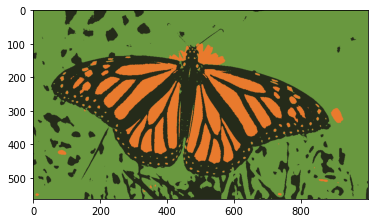

In [4]:
#the below line of code defines the criteria for the algorithm to stop running,
#which will happen is 100 iterations are run or the epsilon (which is the required accuracy)
#becomes 85%
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 
# then perform k-means clustering wit h number of clusters defined as 3
#also random centres are initially choosed for k-means clustering
k = 3
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
 
# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image.shape))
 
plt.imshow(segmented_image)

Now if we change the value of k to 10, we get the following Output

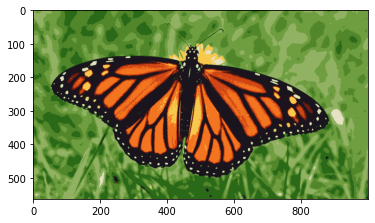

In [6]:
#the below line of code defines the criteria for the algorithm to stop running,
#which will happen is 100 iterations are run or the epsilon (which is the required accuracy)
#becomes 85%
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 
# then perform k-means clustering wit h number of clusters defined as 3
#also random centres are initially choosed for k-means clustering
k = 10
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
 
# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image.shape))
 
plt.imshow(segmented_image)

As you can see with an increase in the value of k, the image becomes clearer and distinct because the K-means algorithm can classify more classes/cluster of colors. K-means clustering works well when we have a small dataset. It can segment objects in images and also give better results. But when it is applied on large datasets (more number of images), it looks at all the samples in one iteration which leads to a lot of time being taken up.



By eye, it is relatively easy to pick out the four clusters. The k-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

Let's visualize the results by plotting the data colored by these labels. We will also plot the cluster centers as determined by the k-means estimator: